# Poiseuille Channel (Velocity-Neumann)

This simulation is used as test for the outlet boundary condition with a fixed pressure. A velocity Bounce-Back BC is used at inlet. The fixed pressure at outlet is meant to avoid a constant increase of the domain average density.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/02_poiseuille_channel_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

In this case, the domain's length is much longer than it is for the periodic cases. This assures that the flow will be able to develop before reaching the outlet.

In [2]:
sim_cfg = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if name == "velocityNeumannPoiseuilleChannel"
)

sim_cfg.full_name

'velocityNeumannPoiseuilleChannel:000'

Extract data from multiblock data from output file of macrs export

In [3]:
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common

extracted_data = {}
array_to_extract = "ux"

export_instantaneous_cfg = sim_cfg.output.instantaneous
macr_export = export_instantaneous_cfg["default"]
time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
reader = macr_export.read_vtm_export(time_step)

p1 = [sim_cfg.domain.domain_size.x / 2, 0.5, 0]
p2 = [sim_cfg.domain.domain_size.x / 2, sim_cfg.domain.domain_size.y - 0.5, 0]
line = common.create_line(p1, p2, sim_cfg.domain.domain_size.y - 1)

# Get the points from the vtkLineSource
polyData = line.GetOutput()
points = polyData.GetPoints()

pos = np.linspace(p1, p2, sim_cfg.domain.domain_size.y)

probe_filter = common.probe_over_line(line, reader.GetOutput())

probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
extracted_data[(sim_cfg.sim_id, sim_cfg.name)] = {"pos": pos, "data": probed_data}

extracted_data.keys()

dict_keys([(0, 'velocityNeumannPoiseuilleChannel')])

Extract data from multiblock data from output file of macrs export for rho plotting

In [4]:
average_data = {}
array_to_extract = "rho"

export_instantaneous_cfg = sim_cfg.output.instantaneous
macr_export = export_instantaneous_cfg["default"]
for time_step in macr_export.interval.get_all_process_steps(sim_cfg.n_steps):
    reader = macr_export.read_vtm_export(time_step)

    multiblock_dataset = reader.GetOutput()
    n_blocks = multiblock_dataset.GetNumberOfBlocks()

    blocks_data = []
    for i in range(n_blocks):
        block = multiblock_dataset.GetBlock(i)
        data_array = vtk_to_numpy(block.GetCellData().GetArray(array_to_extract))
        blocks_data.append(data_array)
    multiblock_avg = np.average(np.concatenate(blocks_data).flatten())

    average_data[(sim_cfg.sim_id, sim_cfg.name, time_step)] = multiblock_avg

average_data

{(0, 'velocityNeumannPoiseuilleChannel', 0): 1.0,
 (0, 'velocityNeumannPoiseuilleChannel', 16000): 1.0222814,
 (0, 'velocityNeumannPoiseuilleChannel', 32000): 1.0222814,
 (0, 'velocityNeumannPoiseuilleChannel', 48000): 1.0222814,
 (0, 'velocityNeumannPoiseuilleChannel', 64000): 1.0222814}

Extract data from multiblock data from output file of macrs export for profile plotting

In [5]:
profile_data = {}
array_to_extract = "ux"

export_instantaneous_cfg = sim_cfg.output.instantaneous
macr_export = export_instantaneous_cfg["default"]
time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
reader = macr_export.read_vtm_export(time_step)

p1 = [0.5, sim_cfg.domain.domain_size.y / 2 - 0.5, 0]
p2 = [
    sim_cfg.domain.domain_size.x - 0.5,
    sim_cfg.domain.domain_size.y / 2 - 0.5,
    0,
]
line = common.create_line(p1, p2, sim_cfg.domain.domain_size.x - 1)

# Get the points from the vtkLineSource
polyData = line.GetOutput()
points = polyData.GetPoints()

pos = np.linspace(p1, p2, sim_cfg.domain.domain_size.x)

probe_filter = common.probe_over_line(line, reader.GetOutput())

probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
profile_data[(sim_cfg.sim_id, sim_cfg.name)] = {"pos": np.array(pos), "data": probed_data}

profile_data.keys()

dict_keys([(0, 'velocityNeumannPoiseuilleChannel')])

## Results

The velocity profile at the end of simulation is compared with the steady state analytical solution below:

Processing functions for Poiseuille Flow case

In [6]:
from typing import Callable


def get_poiseuille_analytical_func() -> Callable:
    """Poiseuille analytical velocity function

    Returns:
        Callable: Analytical velocity function
    """
    return lambda pos: 6 * (pos - pos**2)


def plot_analytical_poiseuille_vels(ax):
    x = np.arange(0, 1.01, 0.01)
    analytical_func = get_poiseuille_analytical_func()
    analytical_data = analytical_func(x)
    ax.plot(x, analytical_data, "--k", label="Analytical")

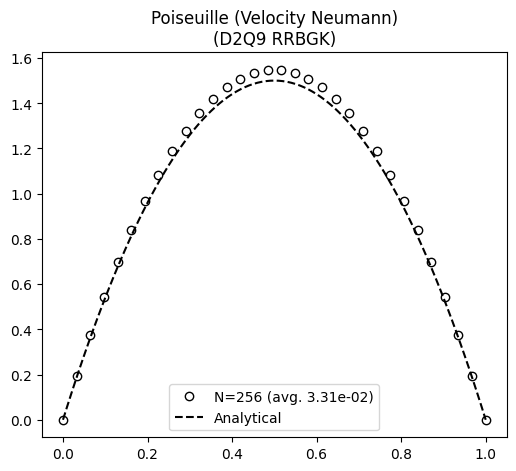

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

style_num = ["o", "^", "s", "+", "x"]

num_data = extracted_data[(sim_cfg.sim_id, sim_cfg.name)]
num_avg_vel = np.average(num_data["data"])
position_vector = (num_data["pos"][:, 1] - 0.5) / (sim_cfg.domain.domain_size.y - 1)
ax.plot(
    position_vector,
    num_data["data"] / num_avg_vel,
    style_num[0],
    label=f"N={sim_cfg.domain.domain_size.x} (avg. {num_avg_vel:.2e})",
    fillstyle="none",
    c="k",
)

plot_analytical_poiseuille_vels(ax)
ax.set_title(
    f"Poiseuille (Velocity Neumann)\n({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})"
)
ax.legend()
plt.show(fig)

The results show that the flow evolution equation from LBM converges to steady analytical solution. 
The average domain's density is shown in the plot below:


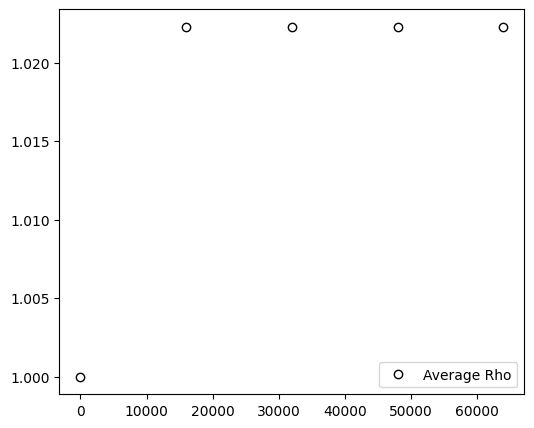

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

plotting_data: list[float] = []
axis_data: list[int] = []

for (_, _, timestep), average_val in average_data.items():
    plotting_data.append(average_val)
    axis_data.append(int(timestep))
ax.plot(axis_data, plotting_data, "ok", label="Average Rho", fillstyle="none")
ax.legend()
plt.show(fig)

It can be seen that the average density quickly stabilizes after certain simulation time.

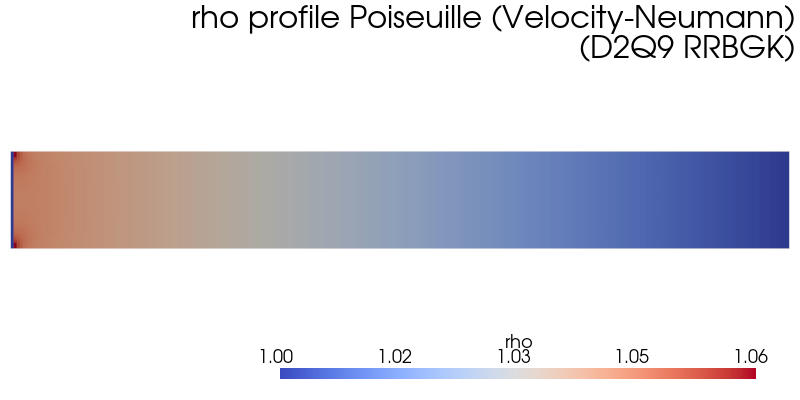

In [9]:
import pyvista as pv

array_to_inspect = "rho"

plotter = pv.Plotter(window_size=(800, 400))

time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
multiblock_file = macr_export.time_step_filename(time_step, ".vtm")
mesh = pv.read(multiblock_file)
mesh.set_active_scalars(array_to_inspect)
plotter.add_mesh(mesh, cmap="coolwarm")

plot_title = f"{array_to_inspect} profile Poiseuille (Velocity-Neumann)\n({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})"
plotter.add_text(plot_title, position="upper_right", font_size=18, color="black")
plotter.camera_position = [(128.0, 16.0, 499.40275054596606), (128.0, 16.0, 1.0), (0.0, 1.0, 0.0)]
plotter.camera.zoom(2)
plotter.show(jupyter_backend="static")
# plotter.show(jupyter_backend='static', cpos="xy", return_cpos=True) # Trick to get automatically the camera position

The pressure profile of the current flow is shown above. Shortly after the inlet, the pressure decays linearly over $x$-direction.

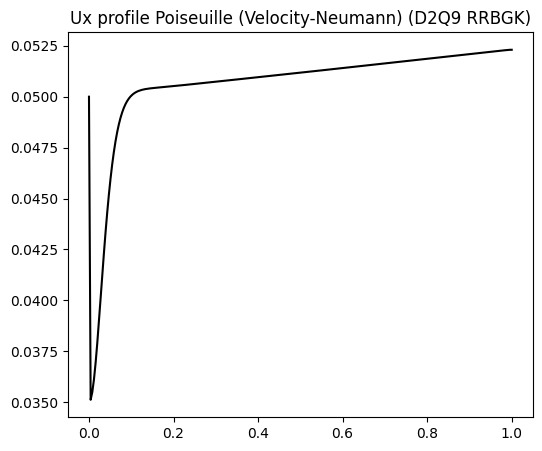

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

num_data = profile_data[(sim_cfg.sim_id, sim_cfg.name)]
position_vector = (num_data["pos"][:, 0] - 0.5) / (sim_cfg.domain.domain_size.x - 1)
ax.plot(position_vector, num_data["data"], c="k")

ax.set_title(
    f"Ux profile Poiseuille (Velocity-Neumann) ({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})"
)
plt.show(fig)

The centerline velocity is shown in the plot above, in which a strong acceleration can be seen close to inlet. After that, the velocity seems to increase almost linearly at very slow rate until the outlet.


## Version

In [11]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 03afae00d1166dcb73bd88413bb3cfda7b6c686c


## Configuration

In [12]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicPoiseuilleChannel
    save_path: ./tests/validation/results/02_poiseuille_channel_flow/periodic

    n_steps: !unroll [250, 1000, 4000, 16000]

    report:
      frequency: 1000

    domain:
      domain_size:
        x: !unroll [4, 8, 16, 32]
        y: !unroll [4, 8, 16, 32]
      block_size: !unroll [4, 8, 8, 8]

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 0 }, macrs: [rho, u] }
      statistics:
        interval: { frequency: 0 }

    models:
      precision:
        default: single

      LBM:
        tau: 0.9
        vel_set: D2Q9
        coll_oper: RRBGK
        F:
          # FX is divided by 8
          x: !unroll [4.0e-4, 5.0e-5, 6.25e-6, 7.8125e-07]
          y: 0

      multiblock:
        overlap_F2C: 1

      engine:
        name: CUDA

      BC:
        periodic_dims: [true, false]
        BC_map:
          - pos: N
            BC: HWBB
            wall_normal: N

          - pos: S
            BC: HWBB
            wall_normal: S

  - name: regularizedPeriodicPoiseuilleChannel
    parent: periodicPoiseuilleChannel

    models:
      LBM:
        coll_oper: RRBGK

      BC:
        periodic_dims: [true, false]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S

  - name: velocityNeumannPoiseuilleChannel
    parent: periodicPoiseuilleChannel

    save_path: ./tests/validation/results/02_poiseuille_channel_flow/velocity_neumann

    report: { frequency: 1000 }

    n_steps: 64000
    domain:
      domain_size:
        x: 256
        y: 32
      block_size: 8

    data:
      instantaneous:
        default: { interval: { frequency: 16000 }, macrs: [rho, u] }

    models:
      LBM: !not-inherit
        tau: 0.9
        vel_set: D2Q9
        coll_oper: RRBGK

      BC:
        periodic_dims: [false, false]
        BC_map:
          - pos: W
            BC: UniformFlow
            wall_normal: W
            rho: 1.0
            ux: 0.05
            uy: 0
            uz: 0
            order: 1

          - pos: E
            BC: RegularizedNeumannOutlet
            rho: 1.0
            wall_normal: E
            order: 1

          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 0

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 0

  - name: velocityNeumannPoiseuilleChannelMultilevel
    parent: periodicPoiseuilleChannel

    save_path: ./tests/validation/results/02_poiseuille_channel_flow/multilevel

    n_steps: 64000

    domain:
      domain_size:
        x: 96
        y: 24
      block_size: 8
      refinement:
        static:
          default:
            volumes_refine:
              - { start: [0, 0], end: [8, 8], lvl: 1, is_abs: true }
              - { start: [0, 16], end: [8, 24], lvl: 1, is_abs: true }
              - { start: [8, 8], end: [24, 16], lvl: 1, is_abs: true }
              - { start: [16, 0], end: [32, 8], lvl: 1, is_abs: true }
              - { start: [24, 16], end: [48, 24], lvl: 1, is_abs: true }
              - { start: [40, 8], end: [48, 16], lvl: 1, is_abs: true }
              - { start: [56, 0], end: [72, 8], lvl: 1, is_abs: true }
              - { start: [80, 8], end: [88, 16], lvl: 1, is_abs: true }
              - { start: [88, 16], end: [96, 24], lvl: 1, is_abs: true }

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 12000 }, macrs: [rho, u, S] }

    models:
      precision:
        default: single

      LBM: !not-inherit
        tau: 0.8
        vel_set: D2Q9
        coll_oper: RRBGK

      engine:
        name: CUDA

      BC:
        periodic_dims: [false, false, true]
        BC_map:
          - pos: W
            BC: UniformFlow
            rho: 1.0
            ux: 0.05
            uy: 0
            uz: 0
       